<a href="https://colab.research.google.com/github/circularmachines/batch_indexing_machine/blob/main/Train_foundation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structuring assorted random parts using siamese networks and triplet loss


This is the latest breakthrough in my quest for finding ways to automatically structure and classify random parts, a tech that can be used to build digital circular economy solutions. If we can effectively document unused parts, it's easier to find new uses for them.

Key features:

*   Works with many different types of parts: Legobricks, metal scrap, whatever really...
*   Works in many different types of machines and scenarios, as long as there is some kind of shaking going on, the algorithm should be able to identify individual parts.
*   Facilitates a modern approach to transfer learning. If i had 1000 movies similar to the one below, but with other batches of random parts, I could do a pre-training on the entire dataset and then fine-tune on one batch.

The data used to train the model in this document is the 5 minute video shown below. At 24 fps that equals rougly 7200 images.

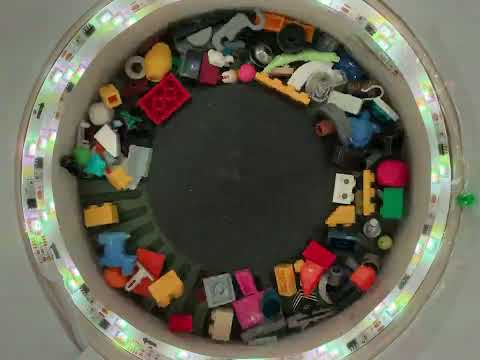

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("NBq8v40ebHE", width=400)

The learning algorithm works by pairing two frames that are roughly from the same time in the movie, not separated by more than 8 frames / 0.33 seconds.

The images are then split into patches of 64x64 pixels, and the areas that doesn't contain any parts are disregarded, leaving this donut shape of random parts.

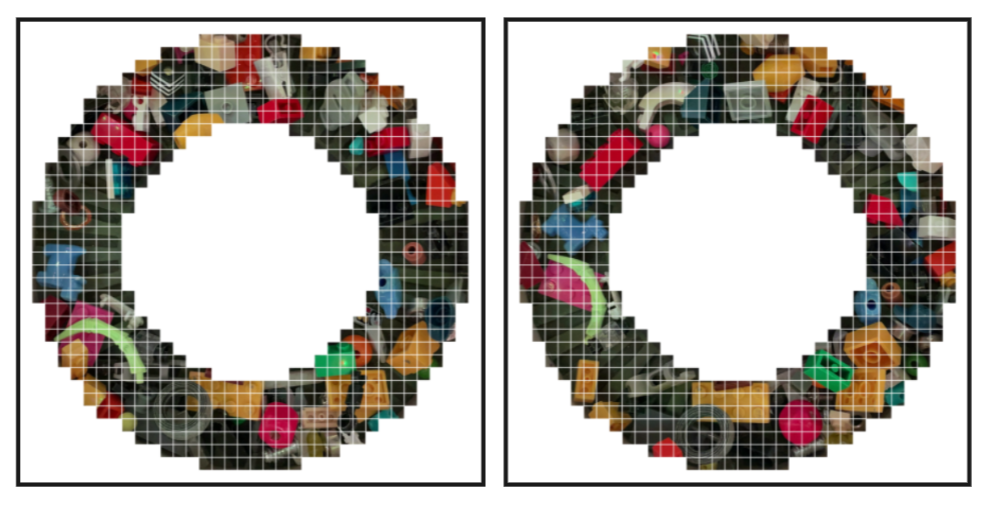

The patches are run through a standard CNN that outputs a l2 normalized feature vector. The goal of the triplet loss is that the feature vector should be similar for images of the same part (anchor to positive), and not similar for images of different parts (anchor to negative). 

For each patch in the left image (anchor), the patch with the most similar feature vector in close proximity to the anchor, but in the right image, is our positive example. The most similar, not in proximity, is our negative anchor.

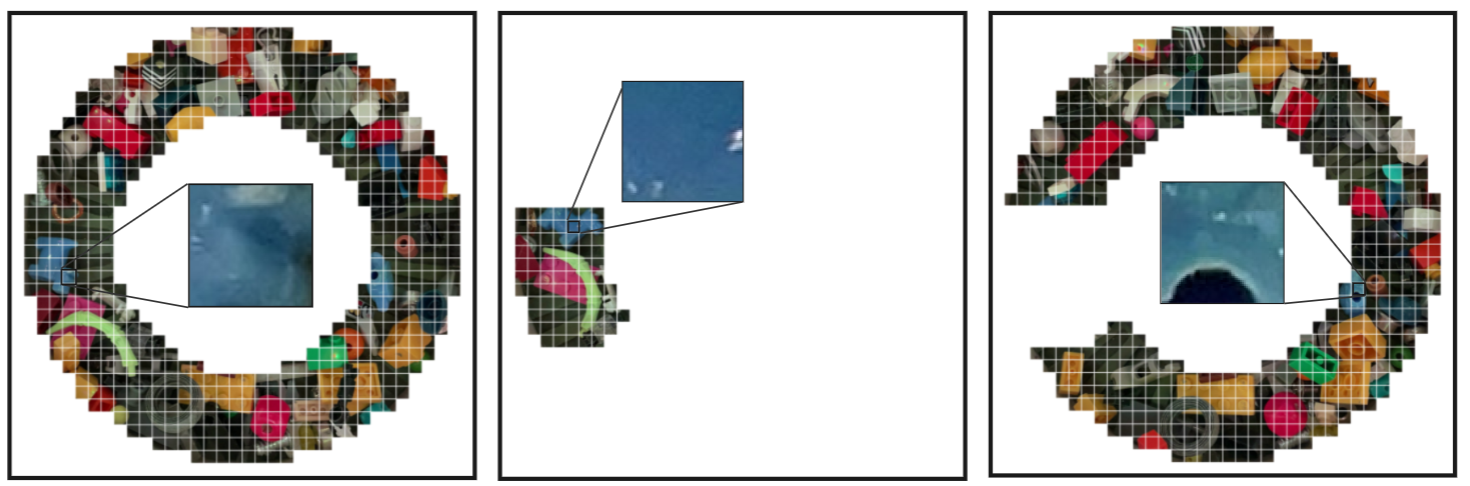


This is a custom adaption of siamese networks with triplet loss learning, as the original is used with labeled examples. The best known usecase for siamese networks are for face recognition, where the model is optimized to provide similar results for different images of the same person.

In [7]:

!git clone https://github.com/circularmachines/batch_indexing_machine.git


fatal: destination path 'batch_indexing_machine' already exists and is not an empty directory.


In [8]:
import numpy as np
import cv2
import tensorflow as tf
import os
from PIL import Image
#from google.colab.patches import cv2_imshow

from batch_indexing_machine import indexer

In [9]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:

image_size=1024
patch_size=64


In [62]:
from huggingface_hub import login
login()


In [12]:
#load "red" dataset

from datasets import load_dataset
ds_list=[]
for i in range(20):
  ds_list.append(load_dataset("Circularmachines/batch_indexing_machine_230529_"+str(i).zfill(3), split="train"))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_013-954ee3b829da894b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_014-f80d0130fc660551/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_015-6e866a7096bd0a37/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_016-23b30998b99d06f0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_017-0ccdc774dd9fd382/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_018-447266bab78b140e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230529_019-a1aa7694bcd99d4e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
#load green dataset ToDo

In [16]:
#!pip install keras-cv --upgrade

In [17]:



def convert_to_tf_tensor(image: Image):
    
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
       # train_data_augmentation(
          convert_to_tf_tensor(image.convert("RGB")) for image in example_batch["image"]  # )
    ]
    #example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    example_batch["pixel_values"] = [tf.squeeze(image) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

[ds.set_transform(preprocess_train) for ds in ds_list]
#food["test"].set_transform(preprocess_val)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [19]:
batch_size=2

#tf_list = [ds.to_tf_dataset(columns=["pixel_values"], shuffle=True,batch_size=batch_size, collate_fn=data_collator) for ds in ds_list]
tf_list = [ds.to_tf_dataset(columns=["pixel_values"], shuffle=False,batch_size=batch_size, collate_fn=data_collator) for ds in ds_list]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [20]:
tf_ds = tf.data.Dataset.sample_from_datasets(tf_list)

In [21]:
for d in tf_ds.take(1):
  show=d[:,:,:,:]
  print(d.shape)

(2, 1024, 1024, 3)


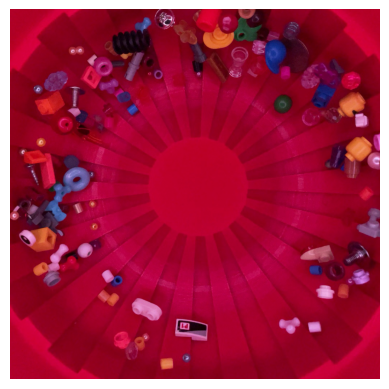

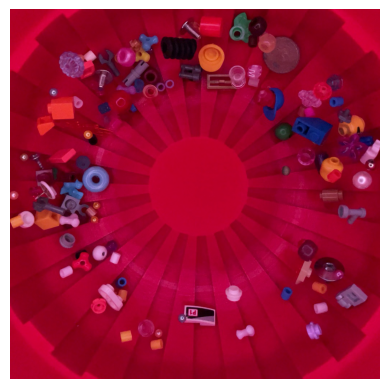

In [22]:
import matplotlib.pyplot as plt

for s in show:

  plt.imshow(s)
  #plt.title(np.where((b[i]==batch_matrix.numpy()).all(axis=1))[0])

  plt.axis('off')


  plt.show()

In [23]:
# Generate the donut shape




def donut(patch_size, img_size, lower_limit=0.4, upper_limit=1):
  
  gridsize=img_size//2//patch_size

  #create a grid of patch coordinates relative to center of image, and calculate distance from center
  coords=np.array([[(i+0.5,j+0.5) for i in range(-gridsize,gridsize)] for j in range(-gridsize,gridsize)])
  norm=np.linalg.norm(coords,axis=2)
  
  #we are only interested in the "donut" where the parts are, anything close to the center and far from the center is disregarded
  keep_bool=((norm>(gridsize*lower_limit))*(norm<(gridsize*upper_limit)))
  keep=tf.constant(np.where(keep_bool.flatten())[0],dtype=tf.int32)

  return coords,keep,keep_bool

coords,keep,keep_bool=donut(patch_size,image_size)
n_patches=len(keep)
n_patches

176

In [24]:

coords_valid=coords.reshape(-1,2)[keep,:]

coords_valid.shape

(176, 2)

In [25]:
angle_sort=(-np.arctan2(coords_valid[:,0],coords_valid[:,1])).argsort()

In [26]:


#!pip install keras-cv --upgrade

#import keras_cv

#def jit(x):
#  x=keras_cv.layers.RandomHue(0.2, [0, 255])(x)
#  x=tf.cast(x,dtype=tf.uint8)
#  return x, 0
  


In [ ]:
#final dataset generation with the patches



def patch(x):
  patches=indexer.Patches(patch_size)(x)
  x=tf.gather(patches,indices=keep)
  x=tf.gather(x,indices=angle_sort)
  return x#, tf.repeat(0,keep.shape[0])

def grey(x):
  x=tf.reduce_mean(x,axis=-1,keepdims=True)
  x=tf.cast(x,dtype=tf.uint8)
  x=tf.repeat(x,3,axis=-1)
  return x

def add_y(x):
  #keras wants (x,y)-pair for training, so we'll add a dummy y that's not being used.
  return x,0


#ds_train=tf_ds.unbatch().batch(1).map(patch).unbatch().map(jit).batch(n_patches*batch_size*2,drop_remainder=True)

ds_train=tf_ds.unbatch().batch(1).map(patch).unbatch().map(add_y).batch(n_patches*batch_size*2,drop_remainder=True)

for d in ds_train.take(1):
  print(d[0].shape)
  batch=d[0]



In [48]:
def create_angle_mask(n,fr,to):

  out=np.zeros((n,n),dtype=int)

  for i in range(n):
    out[i,[x%n for x in range(i+fr,i+to)]]=1

  out=np.concatenate([out-1,2*out-1],axis=1)

  out2=np.zeros((n,n),dtype=int)

  for i in range(n):
    out2[i,[x%n for x in range(i-to+1,i-fr+1)]]=1

  out2=np.concatenate([2*out2-1,out2-1],axis=1)

  return np.concatenate([out,out2])

mask=create_angle_mask(n_patches,8,32)[np.newaxis,:,:]

mask=tf.constant(mask,dtype=tf.float32)



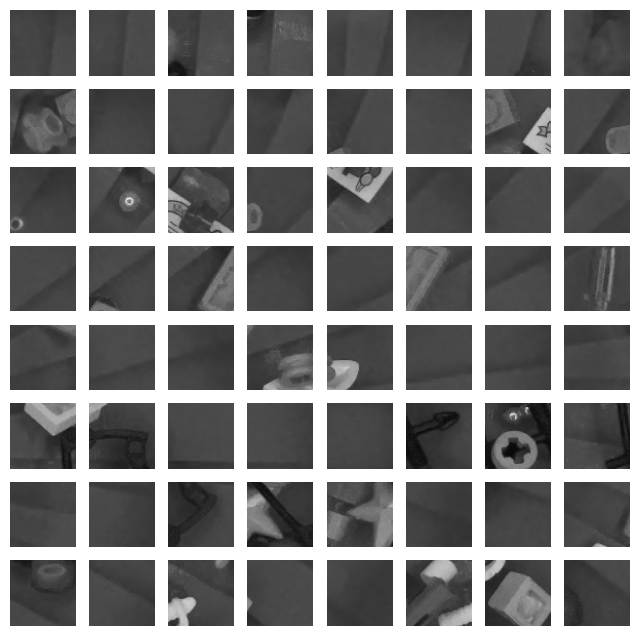

In [31]:
indexer.show_patches(batch[0:64])

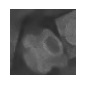

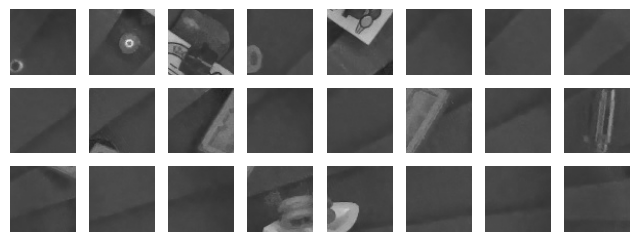

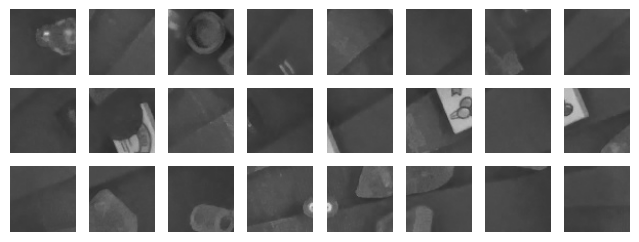

In [34]:
r=8

mask_s=np.squeeze(mask)
batch=batch[:len(mask_s)]

indexer.show_patches([batch[r]])
indexer.show_patches(batch[mask_s[r]==0])
indexer.show_patches(batch[mask_s[r]==1])

In [49]:


# the custom loss algorithm!

def custom_triple_loss(y_true,y_pred):

  

  y_pred=tf.cast(y_pred,mask.dtype)

  a=tf.expand_dims(y_pred,axis=1)
  b=tf.expand_dims(y_pred,axis=2)
  #distance=tf.linalg.norm(a-b,axis=-1)
  distance=tf.reduce_sum(tf.square(a-b),axis=-1)
  distance=tf.sqrt(distance) #contrastive
  #tf.print(distance.shape)

  maskvalid=tf.cast(tf.equal(mask,-1),mask.dtype)
  distance=distance+maskvalid*1000

  mask0=tf.cast(tf.equal(mask,0),mask.dtype)
  min0=tf.reduce_min(distance * (1000-mask0*999),axis=2)    
  mask1=tf.cast(tf.equal(mask,1),mask.dtype)
  min1=tf.reduce_min(distance * (1000-mask1*999),axis=2) 

  margin=0.5
  return  tf.reduce_mean(tf.math.square(min1) + tf.math.square(tf.math.maximum(margin - min0, 0.0))) #contrastive
  #return tf.reduce_mean(tf.maximum(0.0, min1 - min0 + margin)) #triple
      


    

custom_triple_loss(0,np.random.random((4,batch_size*n_patches,64)))



<tf.Tensor: shape=(), dtype=float32, numpy=7.890566>

In [50]:
img_size=patch_size

inp=tf.keras.Input((img_size,img_size,3),name="main_input")

cnn=tf.keras.applications.EfficientNetV2S(include_top=False,input_shape=(img_size,img_size,3),pooling='avg')(inp)

dense_layer=tf.keras.layers.Dense(64,activation=None)(cnn)

l2norm=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_layer) #normalize featurevector along 1st axis, needed for the loss function to work (I think)

reshape=tf.keras.layers.Lambda(lambda x: tf.reshape(x,(-1,n_patches*2,64)))(l2norm)

model=tf.keras.Model(inp,reshape)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 lambda_2 (Lambda)           (None, 64)                0         
                                                                 
 lambda_3 (Lambda)           (None, 352, 64)           0         
                                                                 
Total params: 20,413,344
Trainable params: 20,259,472
Non-trainable params: 153,872
_________________________________________

In [52]:
model.compile(loss=custom_triple_loss, optimizer="adam")


In [57]:
model.fit(ds_train,epochs=2)

3600/3600 [==============================] - 1656s 445ms/step - loss: 0.1140


In [58]:
model.optimizer.learning_rate=0.0005

In [59]:
model.fit(ds_train,epochs=2)

Epoch 1/2
3600/3600 [==============================] - 1574s 437ms/step - loss: 0.1077
Epoch 2/2
 457/3600 [==>...........................] - ETA: 23:14 - loss: 0.1081

KeyboardInterrupt: ignored

In [60]:
model.save_weights('weights.h5')

In [63]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj='/content/weights.h5',
    path_in_repo="weights_red_grey.h5",
    repo_id="Circularmachines/batch_indexing_machine_64x64_triple_loss",
    repo_type="model",
)

weights.h5:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

'https://huggingface.co/Circularmachines/batch_indexing_machine_64x64_triple_loss/blob/main/weights_red_grey.h5'

#test


In [64]:
img_size=patch_size

inp=tf.keras.Input((img_size,img_size,3),name="main_input")#, batch_size=n_patches*8)

cnn=tf.keras.applications.EfficientNetV2S(include_top=False,input_shape=(img_size,img_size,3),pooling='avg')(inp)

dense_layer=tf.keras.layers.Dense(64,activation=None)(cnn)

l2norm=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_layer) #normalize featurevector along 1st axis, needed for the loss function to work (I think)

#reshape=tf.keras.layers.Lambda(lambda x: tf.reshape(x,(-1,n_patches*2,64)))(l2norm)

model=tf.keras.Model(inp,l2norm)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 lambda_4 (Lambda)           (None, 64)                0         
                                                                 
Total params: 20,413,344
Trainable params: 20,259,472
Non-trainable params: 153,872
_________________________________________________________________


In [65]:
model.load_weights('weights.h5')

In [66]:
from datasets import load_dataset

ds_test=load_dataset("Circularmachines/batch_indexing_machine_test",split="test")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_test-d1a7d3e4b3614c1f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [67]:


class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        dim_size = tf.shape(images)[-1]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size//2, self.patch_size//2, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        #patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [-1,self.patch_size,self.patch_size, dim_size])

        return patches

In [70]:
def basic_patch(x):
  #grey
  #x=tf.reduce_mean(x,axis=-1,keepdims=True)
  #x=tf.cast(x,dtype=tf.uint8)
  #x=tf.repeat(x,3,axis=-1)
  
  x=Patches(patch_size)(x)
  return x



In [71]:
ds=tf.data.Dataset.from_tensor_slices(np.array([np.array(d['image']) for d in ds_test])).batch(1).map(basic_patch).unbatch().batch(n_patches*4)
pred=model.predict(ds)
pred.shape

547/547 [==============================] - 77s 138ms/step


(384400, 64)

In [72]:
import pandas as pd

pred_df=pd.DataFrame(np.array(pred).reshape(-1,64))
pred_df.to_csv('test.csv')

In [73]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj='test.csv',
    path_in_repo="test_red_grey.csv",
    repo_id="Circularmachines/Batch_indexing_machine_pred_csv",
    repo_type="dataset",
)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

test.csv:   0%|          | 0.00/294M [00:00<?, ?B/s]

'https://huggingface.co/datasets/Circularmachines/Batch_indexing_machine_pred_csv/blob/main/test_red_grey.csv'

In [39]:

from huggingface_hub import hf_hub_download
# Download from a dataset
file_name=hf_hub_download(repo_id="Circularmachines/batch_indexing_machine_64x64_triple_loss", filename="weights_red.h5")#, repo_type="dataset")
file_name

'/root/.cache/huggingface/hub/models--Circularmachines--batch_indexing_machine_64x64_triple_loss/snapshots/eb073657d754791479d7661972156d34ca8c50ab/weights_red.h5'

In [51]:
model.load_weights(file_name)

In [74]:
from google.colab import runtime
runtime.unassign()